## Estimating envelope functions

Core idea is the "isotropy principle": the marginal distributions of any $\theta$ should be the same at any chosen pitch period. But *joint* draws of $p(\theta|\alpha)$ are heavily correlated by the envelope correlation kernel $k(i,j)$ learned from real data. We assume source and filter have different envelope kernels.

Note 1: for the pitch period envelope, we can make definite predictions about jitter and shimmer values.

Determining bandwidth from formants: (Mehta & Wolfe 2015), better relation: Hawks (1995)

### Envelope learning from Praat estimates

In principle we work with fixed hyperparameters $\hat \alpha$, and predict $p(\theta|\hat\theta,\hat\alpha)$ using a conditioned Gaussian process. In other words, we do not adjust the envelope $\lambda$ or Praat estimation noise $\delta^2$ based on Praat's estimate for the data at hand.

But we could also learn the envelope from $\hat\theta$ by doing MAP over $\alpha$ starting from $\hat\alpha$ or even using nested sampling using $p(\alpha|D)$ as a prior for $\alpha$, where $D$ is the relevant TIMIT dataset. In other words, we learn the envelope parameters $\alpha$ from TIMIT and can represent this information either as a delta prior $p(\alpha|D) = \delta(\alpha-\hat\alpha)$, or retain the uncertainty, e.g. as a Gaussian $p(\alpha|D) = N(\alpha;\hat\alpha,\sigma_\alpha^2)$.

## **Relaxation**

A core theme is that we **relax** our VTR prior into a MVN Gaussian with a nonlinear transformation. This combines best of both worlds: we are strongly opiniated about what the possible VTR values could be, though stand ready to be corrected -- and we acknowledge the fact that ordering is not essential. Our relaxed VTR prior, like the original one (i.e. Pareto chain), succeeds in breaking the invariance symmetry.

In [1]:
%run init.ipy

from dgf.prior import period
from dgf.prior import lf
from dgf import bijectors
from dgf import constants
from lib import lfmodel
from lib import klatt

import pandas as pd

import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

2022-10-27 14:03:36.383898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 14:03:37.186415: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-27 14:03:37.186528: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-27 14:03:37.186540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

[Memory]3.3s, 0.1min    : Loading get_aplawd_training_pairs...


[Memory]16.5s, 0.3min   : Loading run_nested...
[Memory]17.9s, 0.3min   : Loading run_nested...
[Memory]19.3s, 0.3min   : Loading run_nested...
[Memory]20.7s, 0.3min   : Loading run_nested...
[Memory]20.8s, 0.3min   : Loading get_aplawd_training_pairs...


## Formants

In [2]:
from lib import htkio

formant_data, frate, feakind = htkio.htkread("dgf/test/si1149.fb")

formants = formant_data[:3,:].T

formants # kHz

array([[0.60038465, 1.54463804, 2.50881076],
       [0.64932722, 1.5456332 , 2.52436972],
       [0.66138232, 1.47878063, 2.59593034],
       ...,
       [0.62746179, 1.38237345, 2.71759462],
       [0.54841679, 1.44805717, 2.46356225],
       [0.57549101, 1.45660532, 2.39775181]])

GP_regression.,value,constraints,priors
rbf.variance,0.1834167233878824,+ve,
rbf.lengthscale,4.745121705315349,+ve,
Gaussian_noise.variance,0.00029640013967929086,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f2630734e80>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f26306fe580>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f26306fe670>]}

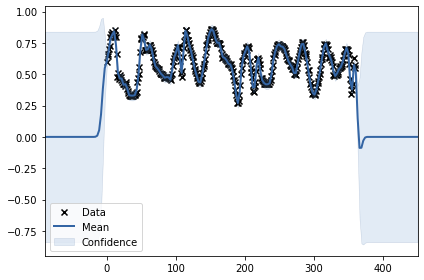

In [3]:
import GPy

X = np.arange(formants.shape[0])[:,None]
Y = formants[:,0][:,None]

kernel = GPy.kern.RBF(input_dim=1)
model = GPy.models.GPRegression(X,Y,kernel)
model.optimize(messages=True)
display(model)
model.plot()

t, u, log_prob_u = lf.sample_and_log_prob_dgf(
    prior,
    jaxkey(),
    num_pitch_periods
)### Prior mean and coveriances for the VTR frequencies

Estimation of prior mean and covariances for the VTR frequencies in the latent log space. Notes:
- The latent MVN in log space is highly correlated and encodes approximately the ordering of the VTRs;
- This correlation should be taken into account (and it strongly breaks the symmetry like our VTR prior)
- The latent MVN in log space underestimates the fat tails of the true distribution of `p(log x)` (which looks similar to a Landau distribution). Thus the VTR frequencies tend to be shy of higher frequencies (say > 2000 Hz). I don't think this will be a problem, as there is still mass at these higher frequencies, but if this turns out to be one, we could apply a FITC-like diagonal correction to the covariance matrix.
- We don't use the pdf weights in estimating the mean and covariance matrices because the correct pdfs of the *truncated* distribution `sample_truncated()` require to evaluate an integral that I don't have time to evaluate
- **Units.** Our log log transformation is not fully kosher because we are log transforming quantities which are not dimensionless. It is indeed possible to do this more properly by log transforming ratios of successive VTR frequencies, as in the Pareto chain prior, but then we cannot guarantee anymore the "isotropy principle", i.e., that the marginal means and variances are constant and do not depend on the particular pitch period chosen. I've also seen MacKay do this, so it's not too bad.

In [4]:
from vtr import sample as paretochain
from dynesty import utils as dyfunc
from dgf import bijectors

def getx(nx, x0, fs, size=1):
    xmax = fs/2
    xbar = x0 + (xmax - x0)/(nx+1)*np.arange(1, nx+1)
    #xbar = 500*np.arange(1, nx+1)
    x = paretochain.sample_truncated(x0, xbar, xmax, size=size)
    return x

size = int(1e5) # 1e5
npoles = 10
x0 = 100/1000
fs = 10000/1000

x = getx(npoles, x0, fs, size) # (n, npoles)
bounds = np.vstack([[x0, fs/2]]*npoles)

# npoles = 4 => cacheid=11723 -- takes # O(1) minutes
# npoles = 10 => cacheid=78238-- takes # O(50) minutes
b = bijectors.fit_nonlinear_coloring_bijector(x, bounds, 78238)

[Memory]26.0s, 0.4min   : Loading run_nested...


DeviceArray([0.25330466, 0.28467316, 0.2328598 , 0.26664565, 0.32543558,
             0.33495571, 0.30553492, 0.33239016, 0.31219826, 0.34715916],            dtype=float64)

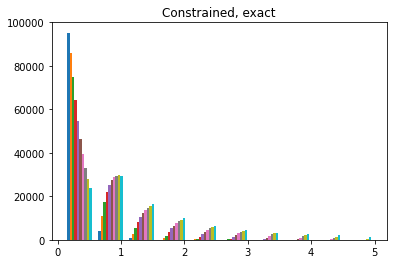

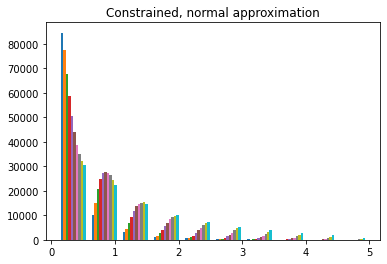

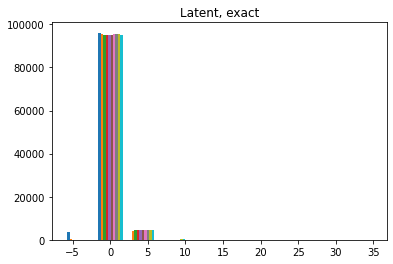

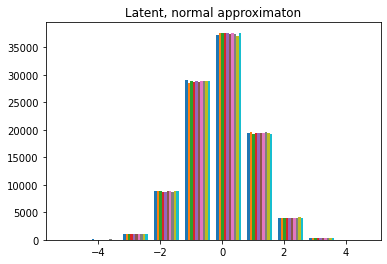

In [5]:
y = asarray(b.inverse(x)) # Latent

ya = randn(size, npoles)
xa = b.forward(ya)

figure()
title("Constrained, exact")
hist(x, bins=10);

figure()
title("Constrained, normal approximation");
hist(asarray(xa), bins=10);

figure()
title("Latent, exact")
hist(y);

figure()
title("Latent, normal approximaton")
hist(ya);

# Sample from the normal approximation
xa[randint(size),:]

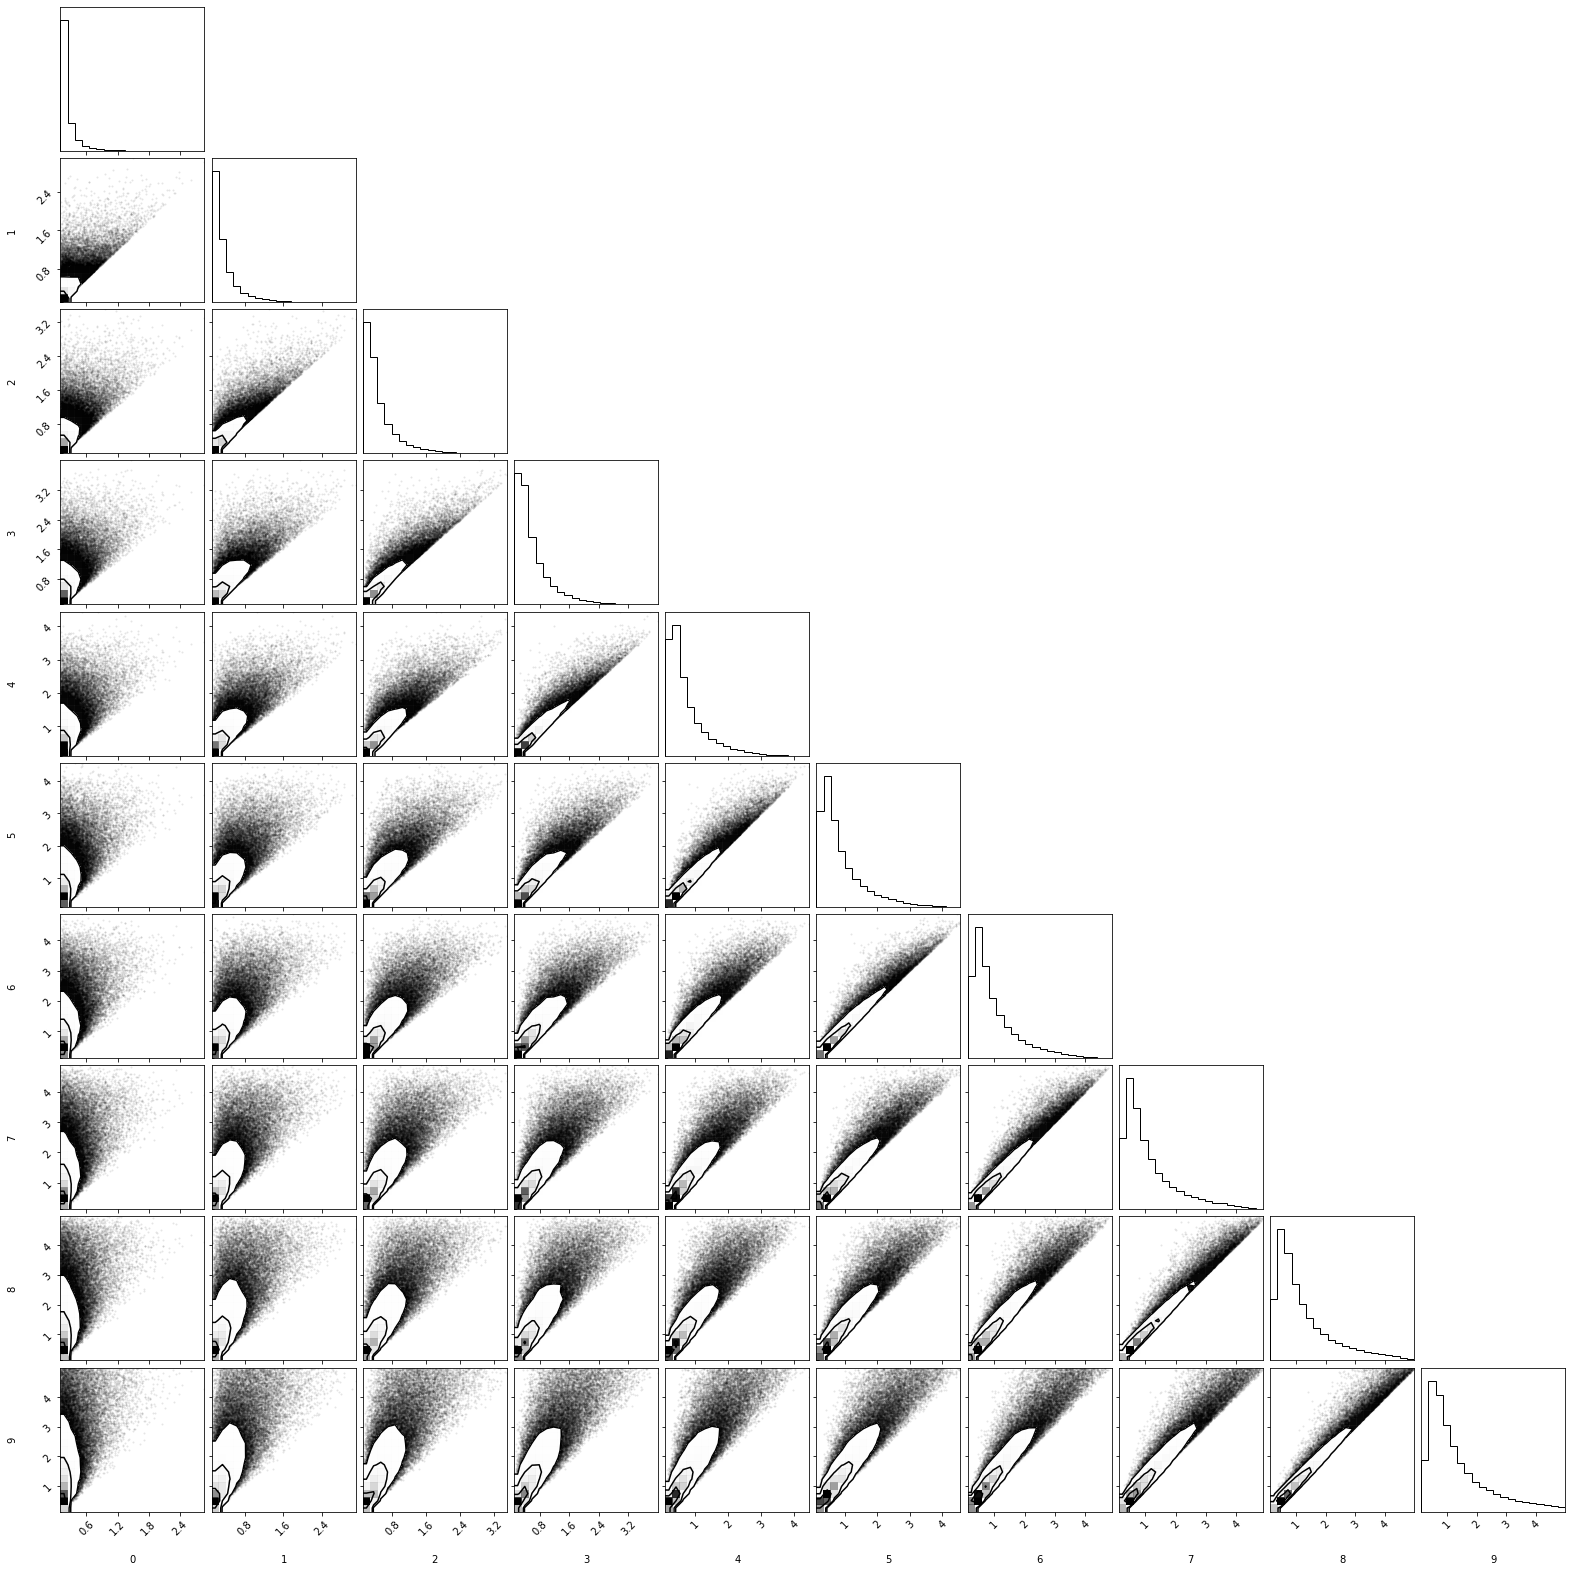

In [6]:
import corner
corner.corner(x, labels=arange(x.shape[1]));

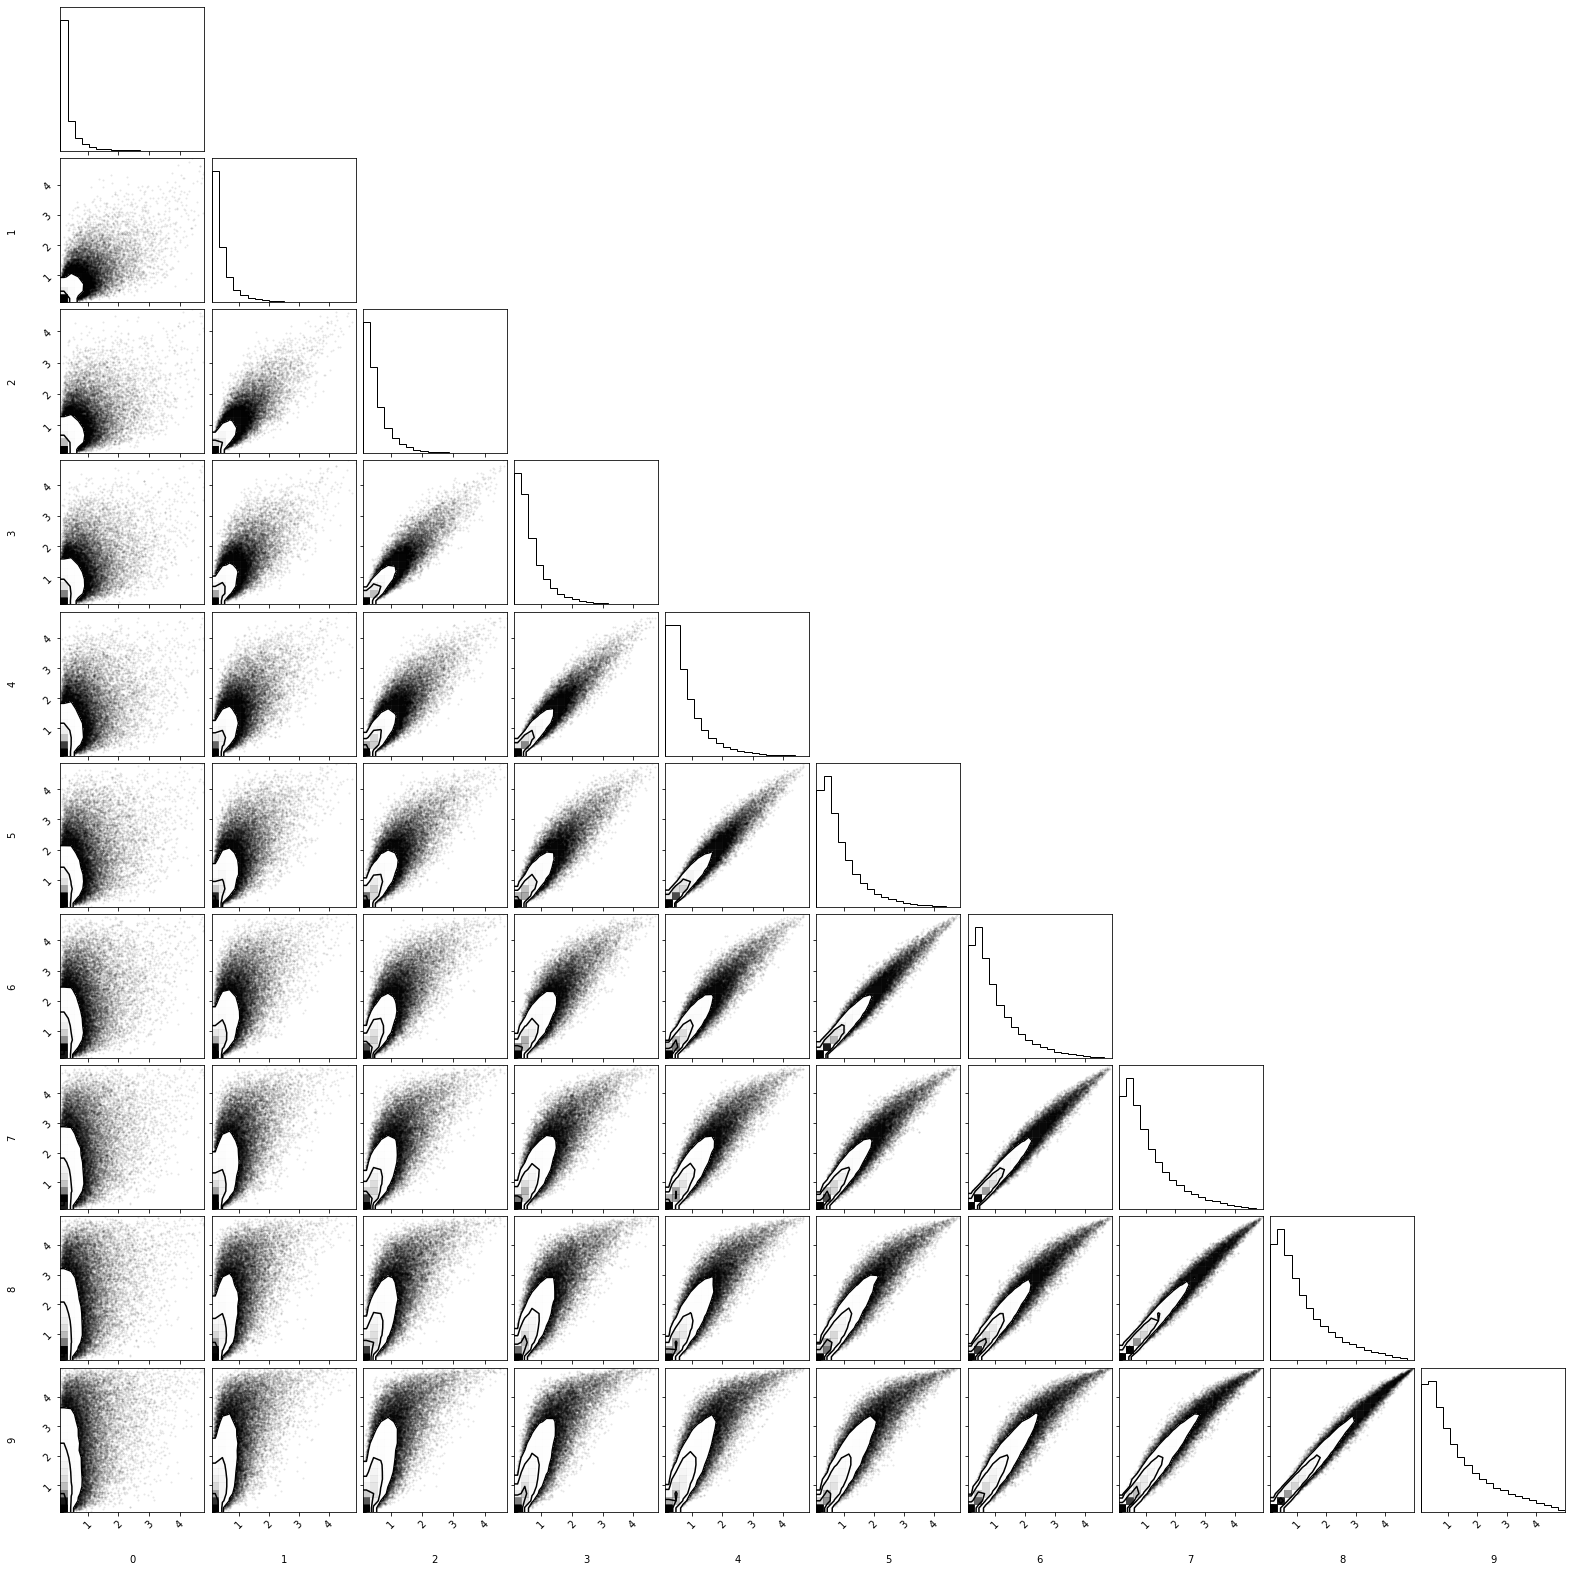

In [7]:
corner.corner(np.array(xa), labels=arange(x.shape[1]));

### VTR frequency trajectories

The covariance function $k([r,i],[s,j]) = k(r,s) k(i,j)$ has Kronecker structure. $k(r,s)$ is the covariance between VTR with indices $r$ and $s$. $k(i,j)$ is the *correlation* (i.e., has unit marginal variance) envelope.

In [8]:
envelope_kernel_name = "SqExponentialKernel"
envelope_lengthscale = 70.
num_pitch_periods = 500

btraj = bijectors.nonlinear_coloring_trajectory_bijector(
    b,
    num_pitch_periods,
    envelope_kernel_name,
    envelope_lengthscale
)

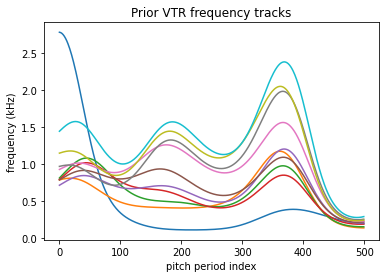

In [9]:
z = randn(npoles*num_pitch_periods)
plot(btraj.forward(z))
title('Prior VTR frequency tracks')
xlabel('pitch period index')
ylabel('frequency (kHz)');

## Check conditioning

In [10]:
%%time
def randz(): return randn(npoles*num_pitch_periods)

observation = btraj.forward(randz())

cbtraj = bijectors.condition_nonlinear_coloring_trajectory_bijector(
    btraj,
    observation,
    np.eye(npoles)*.1 # IID noise
)

CPU times: user 1min 22s, sys: 5.21 s, total: 1min 27s
Wall time: 13.2 s


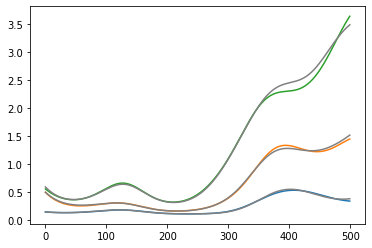

In [11]:
shown = [0,3, 8]

plot(observation[:,shown])

plot(cbtraj.forward(randz())[:,shown], color="grey");

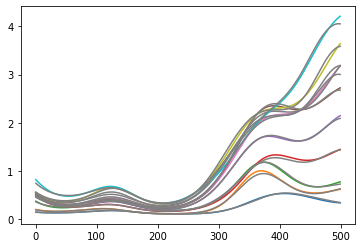

In [12]:
x = observation
y = cbtraj.forward(randz())

plot(x)
plot(y, color="grey");

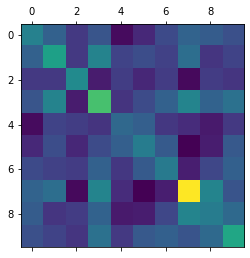

In [13]:
C = bijectors.estimate_observation_noise_cov(
    cbtraj,
    [x, x], [y, y]
)

matshow(C)

In [14]:
cbtraj_cov = bijectors.condition_nonlinear_coloring_trajectory_bijector(
    btraj,
    observation,
    C
)

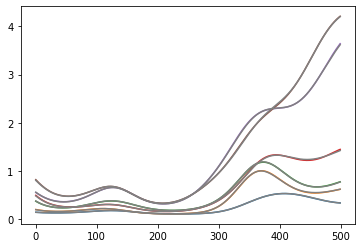

In [15]:
shown = [0, 1, 2, 3, 8, 9]

plot(x[:,shown])

plot(cbtraj_cov.forward(randz())[:,shown], color="grey");

In [16]:
cbtraj_cov.forward(randz())[:,shown]

DeviceArray([[0.14458441, 0.19864694, 0.36634181, 0.49902363, 0.56418521,
              0.8296133 ],
             [0.14369724, 0.19644655, 0.35925089, 0.48764418, 0.55426744,
              0.81469891],
             [0.14284948, 0.19432767, 0.35243319, 0.47666124, 0.54466321,
              0.80016689],
             ...,
             [0.33573094, 0.60967336, 0.77083522, 1.42692883, 3.59745252,
              4.18448722],
             [0.33386219, 0.61255022, 0.7766458 , 1.4342082 , 3.61288499,
              4.1943049 ],
             [0.33203909, 0.61547171, 0.78261915, 1.44163724, 3.62794683,
              4.20371786]], dtype=float64)

## Convolve with LF

In [17]:
from dgf import isokernels
from lib import lfmodel

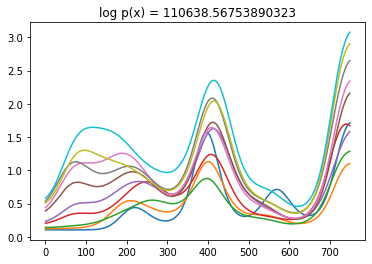

In [18]:
envelope_kernel_name = "SqExponentialKernel"
envelope_lengthscale = 70.
num_pitch_periods = 750

btraj = bijectors.nonlinear_coloring_trajectory_bijector(
    b,
    num_pitch_periods,
    envelope_kernel_name,
    envelope_lengthscale
)

standardnormals = tfd.MultivariateNormalDiag(scale_diag=jnp.ones(npoles*num_pitch_periods))
vtrprior = tfd.TransformedDistribution(
    distribution=standardnormals,
    bijector=btraj
)

x, log_prob_x = vtrprior.experimental_sample_and_log_prob(seed=jaxkey())

plot(x)
title(f"log p(x) = {log_prob_x}");

In [19]:
envelope_kernel_name = 'Matern32Kernel'
envelope_lengthscale = 100.

prior = lf.generic_params_trajectory_prior(
    num_pitch_periods,
    envelope_kernel_name,
    envelope_lengthscale
)

t, u, log_prob_u, context = lf.sample_and_log_prob_dgf(
    prior, jaxkey(), num_pitch_periods, return_full=True
)

[Memory]80.3s, 1.3min   : Loading sample_lf_params...
[Memory]80.8s, 1.3min   : Loading run_nested...


TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [ ]:
plot(t, u)
from lib import klatt
klatt.play(t, u)

In [76]:
import scipy.signal
from dgf import core

from dgf.prior import source

def support(t, T0, offset=0., pre=0, post=1):
    i = lf._nonzero_dgf_indices(t - offset, T0)
    a = max(i[0] - len(i)*pre, 0)
    b = min(i[0] + len(i)*(1+post), len(t))
    return a, b

def convolve(i, ui, xi, t, p):
    """This can be made JAX-compatible with `jax.scipy.linalg.expm()`, as `lsim()` uses `expm()`"""
    # For a real speedup maybe use `scipy.signal.cont2discrete()` and then just `jax.convolve`
    start, end = p['start'][i], p['end'][i]
    a, b = support(
        t, p['T0'][i], offset=t[start],
        pre=0, post=0 # You need 10 if you really want to capture everything
    )
    ut = np.zeros_like(t)
    ut[start:end] = ui
    uu = ut[a:b]
    tt = t[a:b]
    
    print(start, end)
    print(a, b)
    
    # Formant bandwidths
    # followed the relation bandwidth = 80 + 120*frequency/5000 (Mehta & Wolfe 2015)
    # Better relation: Hawks (1995)
    freqs = xi*1000
    bandwidths = 80 + 120*freqs/5000
    q = core.make_poles(bandwidths, freqs)

    zeros = np.array([])
    poles = np.hstack([q, np.conj(q)])
    gain = np.prod(np.abs(q)**2)

    T, y, _ = scipy.signal.lsim((zeros, poles, gain), uu, tt)
    out = np.zeros_like(t)
    out[a:b] = y
    return out

p = context['p']
us = context['us']
t = np.array(t)

conv = np.array([convolve(i, ui, xi, t, p) for i, (xi, ui) in enumerate(zip(x, us))])
out = np.nansum(conv, axis=0)

0 58
0 58


 /home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/scipy/sparse/linalg/_matfuncs.py:708: LinAlgWarning:Ill-conditioned matrix (rcond=1.46624e-22): result may not be accurate.


ValueError: could not broadcast input array from shape (59,) into shape (58,)

[Memory]436.8s, 7.3min  : Loading sample_lf_params...
________________________________________________________________________________
[Memory] Calling dgf.bijectors.run_nested...
run_nested(98171, {'nlive': 50}, {'save_bounds': False})


1309it [00:20, 64.32it/s, +50 | bound: 56 | nc: 1 | ncall: 5977 | eff(%): 22.929 | loglstar:   -inf < 17945.796 <    inf | logz: 17922.727 +/-  0.651 | dlogz:  0.001 >  0.059]


______________________________________________________run_nested - 21.9s, 0.4min


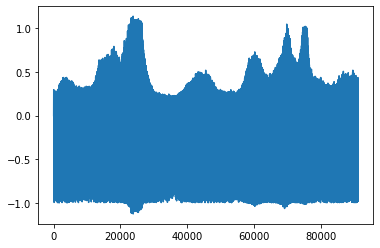

In [24]:
envelope_kernel_name = 'Matern32Kernel'
envelope_lengthscale = 100.

prior = lf.generic_params_trajectory_prior(
    num_pitch_periods,
    envelope_kernel_name,
    envelope_lengthscale
)

sample, logprob_sample = prior.experimental_sample_and_log_prob(seed=jax.random.PRNGKey(randint(1000)))

p = lf.generic_params_to_dict(sample)
p = lfmodel.convert_lf_params(p, 'generic -> T')

GOI = jnp.cumsum(p['T0']) - p['T0'][0]
end = GOI[-1] + p['T0'][-1]
t = np.linspace(0, end, int(end*fs))

def warn_if_nans(u):
    mask = jnp.any(jnp.isnan(u), axis=1)
    if jnp.sum(mask) > 0:
        pitch_period_indices = jnp.where(mask)[0]
        import warnings
        warnings.warn(
            'Inconsistent LF parameters detected at the following pitch '
            f'period indices: {pitch_period_indices}'
        )

u = jax.vmap(jax.jit(lfmodel.dgf), in_axes=[None, 0, 0])(t, p, GOI)
warn_if_nans(u)
plot(jnp.nansum(u, axis=0))

In [237]:
from lib import klatt
klatt.play(t, jnp.nansum(u, axis=0))

In [238]:
import scipy.signal
from dgf import core

from dgf.prior import source

def support(t, T0, offset=0., pre=0, post=1):
    i = source._nonzero_dgf_indices(t - offset, T0)
    a = max(i[0] - len(i)*pre, 0)
    b = min(i[0] + len(i)*(1+post), len(t))
    return a, b

def convolve(i, u_prime, x):
    """This can be made JAX-compatible with `jax.scipy.linalg.expm()`, as `lsim()` uses `expm()`"""
    # For a real speedup maybe use `scipy.signal.cont2discrete()` and then just `jax.convolve`
    
    a, b = support(t, p['T0'][i], offset=GOI[i], pre=0, post=10) # You need 10 if you really want to capture everything
    
    # Formant bandwidths
    # followed the relation bandwidth = 80 + 120*frequency/5000 (Mehta & Wolfe 2015)
    # Better relation: Hawks (1995)
    freqs = x*1000
    bandwidths = 80 + 120*freqs/5000
    q = core.make_poles(bandwidths, freqs)

    zeros = np.array([])
    poles = np.hstack([q, np.conj(q)])
    gain = np.prod(np.abs(q)**2)

    T, y, _ = scipy.signal.lsim((zeros, poles, gain), u_prime[a:b], t[a:b])
    out = np.zeros_like(u_prime)
    out[a:b] = y
    return out

In [239]:
conv = np.array([convolve(i, ui, xi) for i, (xi, ui) in enumerate(zip(x, u))])
out = np.nansum(conv, axis=0)

In [240]:
#plot(t, conv.T); # Takes a long time to draw

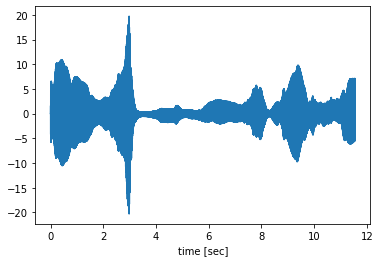

In [241]:
plot(t/1000, out)
xlabel("time [sec]");

In [242]:
klatt.play(t, out)

Measure freq and bandwidths trajectories from Praat, then sample from the trajectories conditioned on them. 

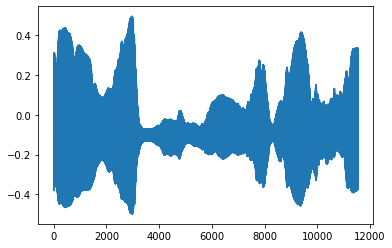

In [243]:
def compress(a, factor=0.75):
    from scipy.special import expit
    m, s = np.mean(a), np.std(a)
    x = (a - m)/s
    return expit((x - 0.5)*factor) - 0.5
        
plot(t, compress(out))
klatt.play(t, compress(out))

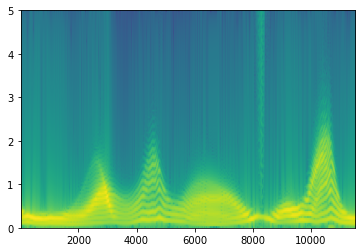

In [253]:
specgram(out, Fs=fs);